# 1. Preprocessing & Dataset Summarization
This notebook is meant for:
- getting statistics about our dataset
- preprocessing the large tif files into smaller sub-images (i.e. "patches")
- getting statistics for our patches
- clustering our pateches to get psuedolabels

### Imports: packages and helpers

In [46]:
import os
import glob
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile as tiff

# helpers
from utils import labels_dict
from dataloader import DataLoader
from preprocess import reshape_4dto3d, summarize_embed, analyze_embed, patchify

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Facts about Image dataset: 
- dimensions
- dataset size
- preliminary channel-wise summaries of each image

In [2]:
data_dir1 = "/home/groups/plevriti/gautam/codex_analysis/codex-analysis/data_u54/primary"

In [44]:
f = "median"
m = "image"
study_arms, summary_im_df = summarize_embed(data_dir1, feat=f, mode=m)    

Processing: reg015_montage.tif
Processing: reg011_montage.tif
Processing: reg023_montage.tif
Processing: reg008_montage.tif
Processing: reg019_montage.tif
Processing: reg024_montage.tif
Processing: reg004_montage.tif
Processing: reg030_montage.tif
Processing: reg012_montage.tif
Processing: reg034_montage.tif
Processing: reg006_montage.tif
Processing: reg027_montage.tif
Processing: reg016_montage.tif
Processing: reg007_montage.tif
Processing: reg017_montage.tif
Processing: reg014_montage.tif
Processing: reg005_montage.tif
Processing: reg020_montage.tif
number of images: 18 | number of channels/image: 84


total images/patients: 18
validation images: 4
test images: 4
train images: 10


/home/users/gmachi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """Entry point for launching an IPython kernel.


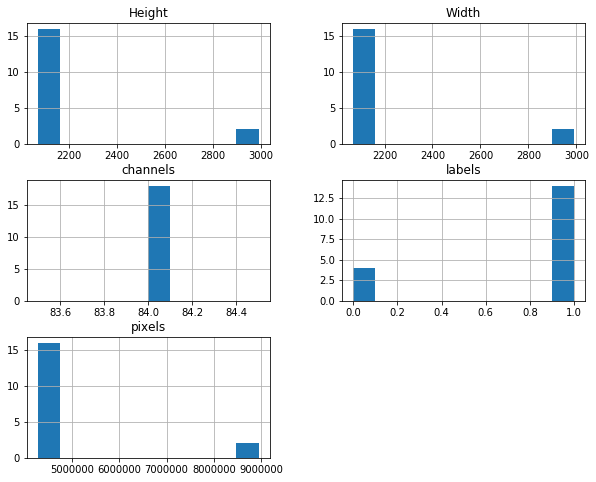

KeyError: "The following 'id_vars' are not present in the DataFrame: ['IDs']"

In [62]:
summary_im, train_im_df, train_im_dfl = analyze_embed(study_arms, summary_im_df)

### Patchify the images into our patch tensors

In [48]:
save_dir = "/home/groups/plevriti/gautam/codex_analysis/codex-analysis/patches/"

In [40]:
# only toggle/run below command if starting from scratch:
# patchify(data_dir1, save_dir)

on file reg017_montage.tif
original size: (21, 4, 2990, 2990)
--------------
edge cropping...
shifted cropping...
Images completed: 1, Last image patches: 961, tossed: 0
on file reg014_montage.tif
original size: (21, 4, 2070, 2070)
--------------
edge cropping...
shifted cropping...
Images completed: 2, Last image patches: 441, tossed: 7


### Patch statistics

In [49]:
train_patch_dir = save_dir + 'train'
val_patch_dir = save_dir + 'val'
test_patch_dir = save_dir + 'test'

train_len = len(os.listdir(train_patch_dir))
val_len = len(os.listdir(val_patch_dir))
test_len = len(os.listdir(test_patch_dir))

print(train_len, val_len, test_len)

28684 4449 4507


In [60]:
f = "median"
m = "patch"
study_arms, summary_patch_df = summarize_embed(train_patch_dir, feat=f, mode=m)   

Processing: 1000 patches
number of images: 1000 | number of channels/image: 75


total images/patients: 1000
validation images: 0
test images: 0
train images: 1000


/home/users/gmachi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """Entry point for launching an IPython kernel.


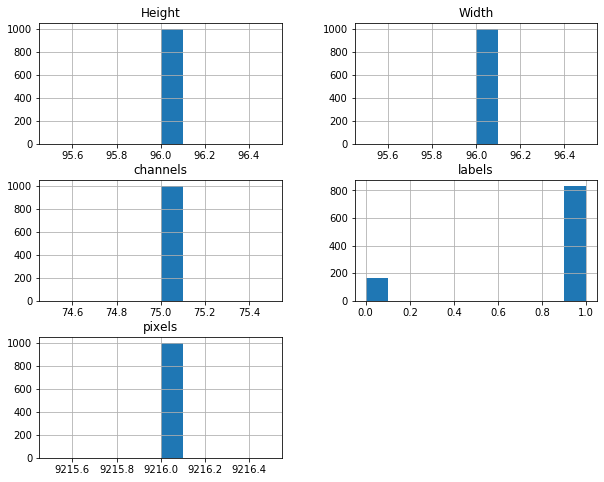

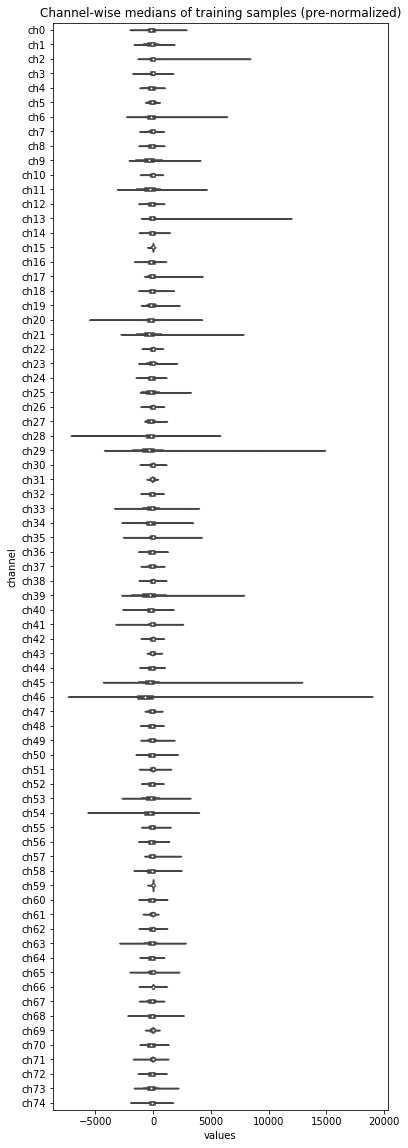

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.141s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 112.303248
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.918015
[t-SNE] KL divergence after 300 iterations: 0.459198


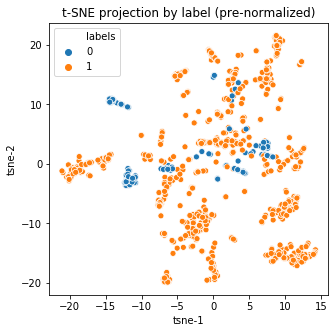

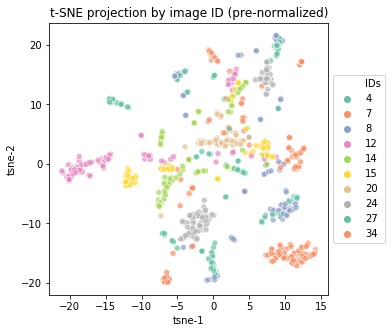

In [80]:
summary_patch, train_patch_df, train_patch_dfl = analyze_embed(study_arms, summary_patch_df, mode=m)

In [68]:
print(set(train_patch_df["IDs"].astype(np.int)))
print(set(train_patch_df["IDs"]))

{34, 4, 7, 8, 12, 14, 15, 20, 24, 27}
{'024', '014', '007', '004', '020', '012', '015', '008', '034', '027'}


# Sampling to acheive dev/test prevalence of 0.6 +cases

# Normalization

In [ ]:
new_train_dir = '/home/data/train_norm/'
new_test_dir = '/home/data/test_norm/'
new_val_dir = '/home/data/val_norm/'

In [ ]:
train_loader = DataLoader(utils.train_dir, batch_size=24, transfer=False)
val_loader = DataLoader(utils.val_dir, batch_size=24, transfer=False)
test_loader = DataLoader(utils.test_dir, batch_size=24, transfer=False)

In [ ]:
for f, x, y in tqdm(train_loader):
    for i in range(len(f)):
        dat = x[i]
        new_x = dat - np.mean(dat, axis=(1,2)).reshape(-1,1,1)
        new_x /= (np.std(new_x, axis=(1,2)).reshape(-1,1,1) + 1e-5)
        np.save(new_train_dir + f[i], new_x)

In [ ]:
for f, x, y in tqdm(val_loader):
    for i in range(len(f)):
        dat = x[i]
        new_x = dat - np.mean(dat, axis=(1,2)).reshape(-1,1,1)
        new_x /= (np.std(new_x, axis=(1,2)).reshape(-1,1,1) + 1e-5)
        np.save(new_train_dir + f[i], new_x)

# Psuedolabels / patch clustering

# Making random patches to test validity of downstream analysis